In [52]:
%load_ext autoreload
%autoreload 2
import os, pickle, csv, itertools, shutil, random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torchvision, torch
import scipy
# from torchvision import transforms
from omegaconf import OmegaConf as oc

%matplotlib inline
%config InlineBackend.figure_format='retina'

import utils.utils as utils
import evals.embed_evals as evals
import utils.plot_data as plot
import utils.gen_triplets as gen
import models.transforms as transforms
import algorithms.teaching_algs as algs

import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
z_train = pickle.load(open("data/embeds/wv/align=0.5/MTL_train_d50_seed42.pkl","rb"))
z_test = pickle.load(open("data/embeds/wv/align=0.5/MTL_test_d50_seed42.pkl","rb"))
syn_x_train = pickle.load(open("data/datasets/wv_3d_square/train_features.pkl","rb"))
syn_x_test = pickle.load(open("data/datasets/wv_3d_square/test_features.pkl","rb"))

train = torchvision.datasets.ImageFolder(f"data/datasets/wv_3d_square/train")
test = torchvision.datasets.ImageFolder(f"data/datasets/wv_3d_square/test")
y_train = np.array([x[1] for x in train])
y_test = np.array([x[1] for x in test])
y_pred = y_test

In [77]:
def decision_support(x_train, y_train, x_test, y_test, examples, weights, powers):
    """ decision support acc given examples and weights to human distance """
    correct = 0
    err = []
    preds = []
    m = []
    for test_idx, examples_idx in enumerate(examples):
        examples_idx = examples_idx.flatten()
        if len(np.unique(examples_idx)) < len(examples_idx): ## signal of error in rNINO
            err.append([test_idx, examples_idx[0], examples_idx[1]])
            continue
        ref = x_test[test_idx]
        
        dist_fn = lambda x, y: evals.weightedPdist(x, y, weights, powers)
        dists = [dist_fn(ref, x_train[idx]) for idx in examples_idx]
        y_pred = y_train[examples_idx[np.argmin(dists)]]
        if y_pred == y_test[test_idx]: 
            correct += 1
            preds.append(1)
        else: 
            err.append([test_idx, examples_idx[0], examples_idx[1]])
            preds.append(0)

        m.append(metrics(ref, x_train[examples_idx[0]], x_train[examples_idx[1]], dists, dist_fn))

    return correct/len(y_test), preds, np.array(m)

def metrics(ref, e1, e2, dists, dist_fn):
    """ return metric to calculate correlation """
    d1, d2 = dists
    metric_0 = d1
    metric_1 = d2
    metric_2 = d1/(d1+d2)
    metric_3 = d2/(d1+d2)
    metric_4 = abs(d1-d2)
    metric_5 = dist_fn(e1, e2)

    return np.array([metric_0, metric_1, metric_2, metric_3, metric_4]).flatten()

def corr(x,y):
    plt.scatter(y,x)
    plt.show()
    return scipy.stats.pearsonr(x, y)[0]

In [11]:
weights, powers = [0,0,1,1], [2,2]

In [6]:
results = evals.syn_evals(z_train, y_train, z_test, y_test, y_pred, syn_x_train, syn_x_test, weights, powers)

In [83]:
euc_dist_M = evals.euclidean_distances(z_test,z_train)
NINO = evals.get_NINO(euc_dist_M, y_train, y_pred, 1)
NINO = evals.get_NIFO(euc_dist_M, y_train, y_pred, 1)
NINO_ds_acc, preds, m = decision_support(syn_x_train, y_train, syn_x_test, y_test, NINO, weights, powers)

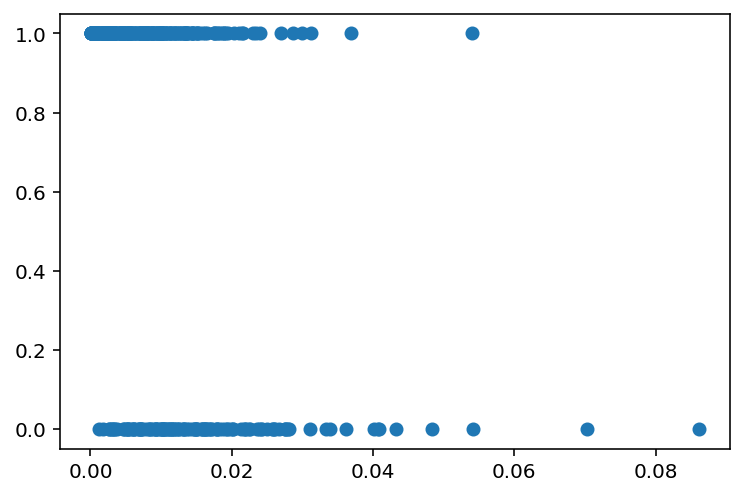

-0.40802330016333344

In [79]:
corr(preds, m[:,0])

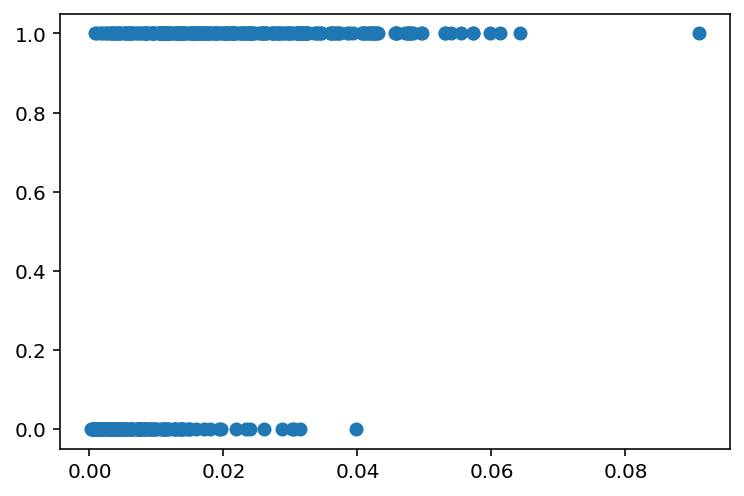

0.4899956168259112

In [80]:
corr(preds, m[:,1])

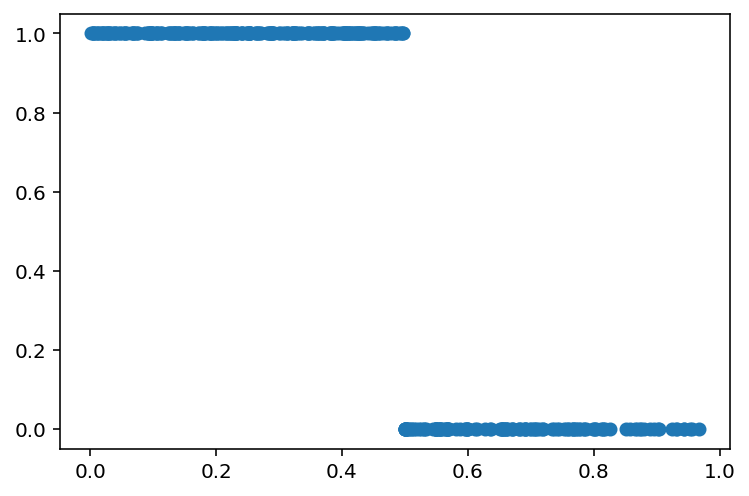

-0.8235371956263806

In [82]:
corr(preds, m[:,2])

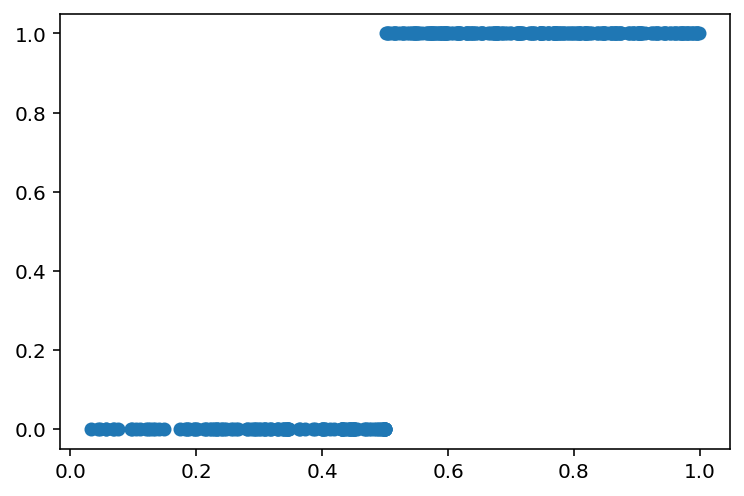

0.8235371956263807

In [81]:
corr(preds, m[:,3])

In [12]:
idx = np.random.choice(np.arange(1583),500,replace=False)
for f in class_a[idx]:
    f = f[0]
    img_name = f.split("/")[-1]
    dst = f"/net/scratch/tianh-shared/pneumonia/pneumonia_1k/0/{img_name}"
    shutil.copy(f, dst)
idx = np.random.choice(np.arange(1583),500,replace=False)
for f in class_b[idx]:
    f = f[0]
    img_name = f.split("/")[-1]
    dst = f"/net/scratch/tianh-shared/pneumonia/pneumonia_1k/1/{img_name}"
    shutil.copy(f, dst)

In [150]:
algs.protodash(X, 10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [39]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA

In [63]:
pca_dims = PCA()
pca_dims.fit(X_flat)
cumsum = np.cumsum(pca_dims.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [64]:
pca = PCA(n_components=120).fit_transform(X_flat)
X_reduced = pca.fit_transform(X_flat)
X_recovered = pca.inverse_transform(X_reduced)

In [65]:
X_recovered.shape


(120, 150528)

In [53]:
X_reduced.shape

(120, 120)

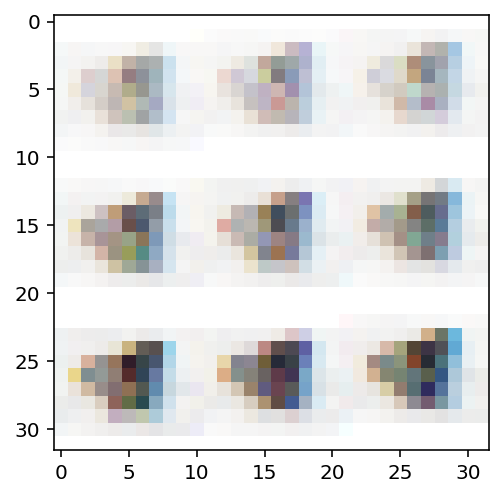

In [142]:
plt.imshow(dataset[0][0].reshape((32,32,3)))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


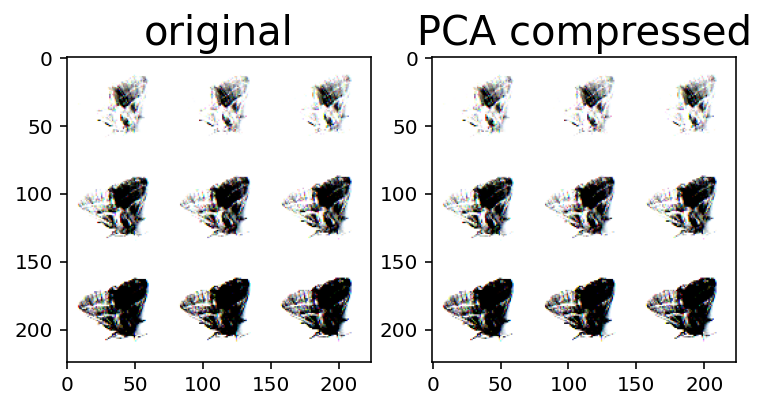

In [67]:
f = plt.figure()
f.add_subplot(1,2, 1)
plt.title("original")
plt.imshow(X_flat[0].reshape((224,224,3)))
f.add_subplot(1,2, 2)

plt.title("PCA compressed")
plt.imshow(X_reduced[0].reshape((120,120,3 )))
# plt.show(block=True)